In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import tifffile
import numpy as np
from sklearn.cluster import DBSCAN
from scipy.spatial import ConvexHull
from pathlib import Path

DB_EPS = 40
DB_MIN_SAMPLES = 5

def frame_counts(csv_file, frames):
    spots = pd.read_csv(csv_file, skiprows=[1, 2, 3], low_memory=False)
    if not isinstance(frames, list):
        frames = [frames]
    counts = []
    for f in frames:
        counts.append(len(spots[spots["FRAME"] == f]))
    return counts

def frame_clusters_with_dbscan(csv_file, frame, db_eps=DB_EPS, db_min_sample=DB_MIN_SAMPLES):
    spots = pd.read_csv(csv_file, skiprows=[1, 2, 3], low_memory=False)
    spots_frame = spots[spots["FRAME"] == frame]
    pos_x = spots_frame["POSITION_X"].values
    pos_y = spots_frame["POSITION_Y"].values
    pos = np.vstack((pos_x, pos_y)).T
    if len(pos) == 0:
        return 0, pos, []
    clustering = DBSCAN(eps=DB_EPS, min_samples=DB_MIN_SAMPLES).fit(pos)
    num_clusters = len(set(clustering.labels_)) - (1 if -1 in clustering.labels_ else 0)
    return num_clusters, pos, clustering.labels_

def plot_clusters(ax, img, frame, pos, labels):
    with tifffile.TiffFile(img) as tif:
        frame_img = tif.pages[frame*2].asarray()
    ax.imshow(frame_img, cmap="gray")
    for label in set(labels):
        if label == -1:
            continue
        cluster_pos = pos[labels == label]
        if len(cluster_pos) < 3:
            print("Skipping cluster with less than 3 points: ", img)
            continue
        hull = ConvexHull(cluster_pos)
        ax.plot(cluster_pos[hull.vertices, 0], cluster_pos[hull.vertices, 1], "r-")

def get_files_list(root):
    root = Path(root)
    return [root/f for f in os.listdir(root) if not f.startswith('.')]

In [2]:
PROJECT_ROOT = Path("/Users/ashkanhzdr/workspace/ViralTally")
DATASET_ROOT = PROJECT_ROOT / "dataset" / "Sars2Plaque"

dmso_csv_files = get_files_list(DATASET_ROOT / "trackmate" / "ACE2_A549_DMSO")
dmso_img_files = get_files_list(DATASET_ROOT / "processed" / "ACE2_A549_DMSO")

inhibitor_csv_files = get_files_list(DATASET_ROOT / "trackmate" / "ACE2_A549_inhibitor")
inhibitor_img_files = get_files_list(DATASET_ROOT / "processed" / "ACE2_A549_inhibitor")

DMSO
Skipping cluster with less than 3 points:  /Users/ashkanhzdr/workspace/ViralTally/dataset/Sars2Plaque/processed/ACE2_A549_DMSO/A03_s3.tiff


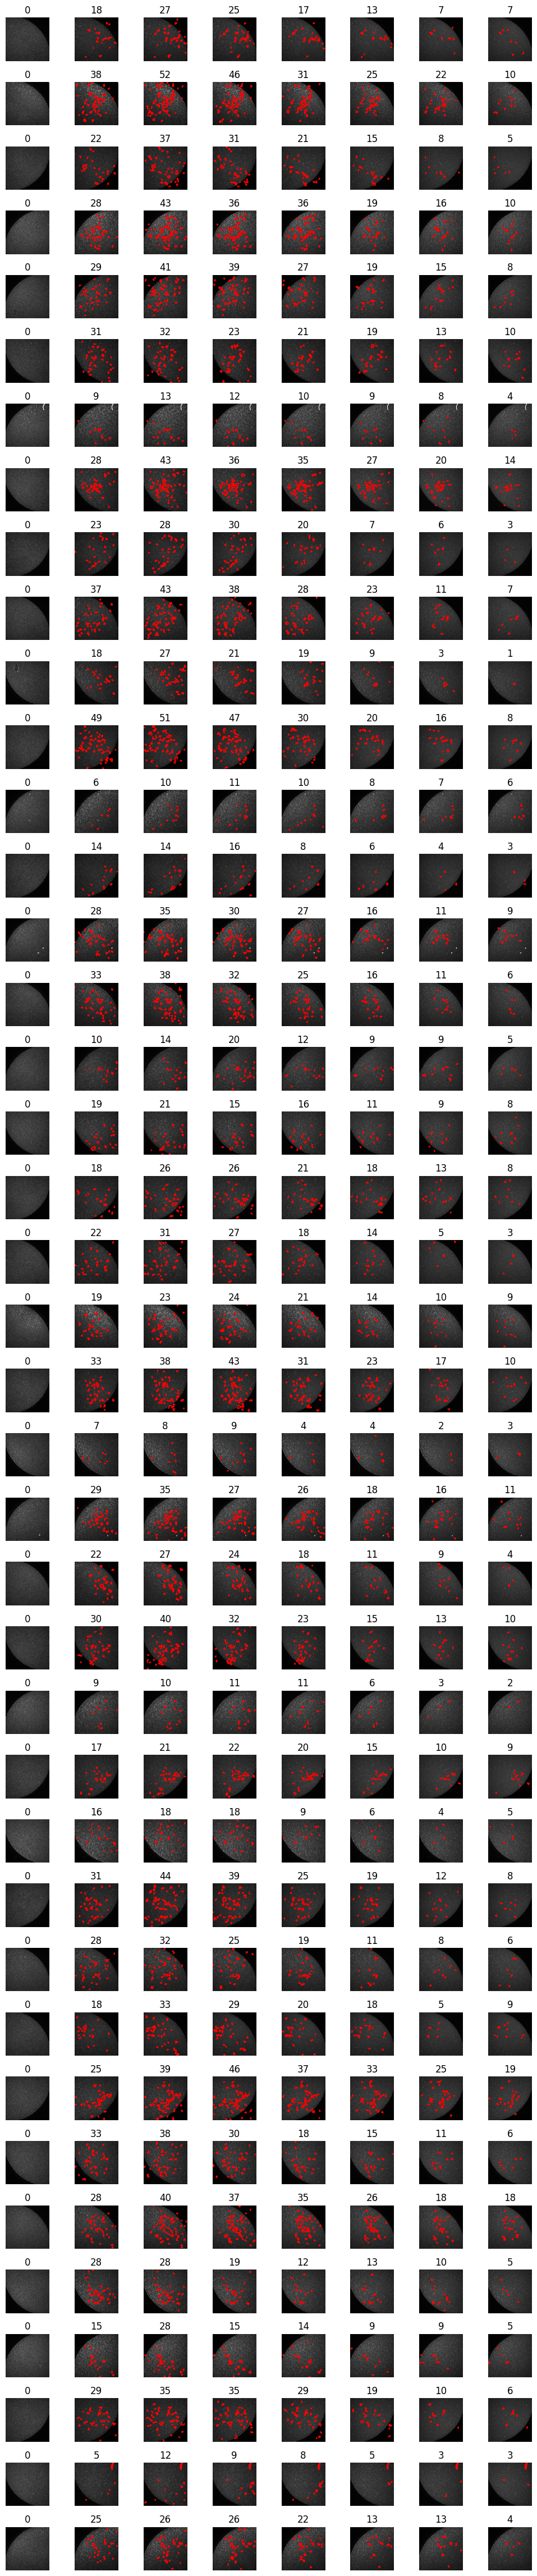

Inhibitor
Skipping cluster with less than 3 points:  /Users/ashkanhzdr/workspace/ViralTally/dataset/Sars2Plaque/processed/ACE2_A549_inhibitor/G02_s4.tiff


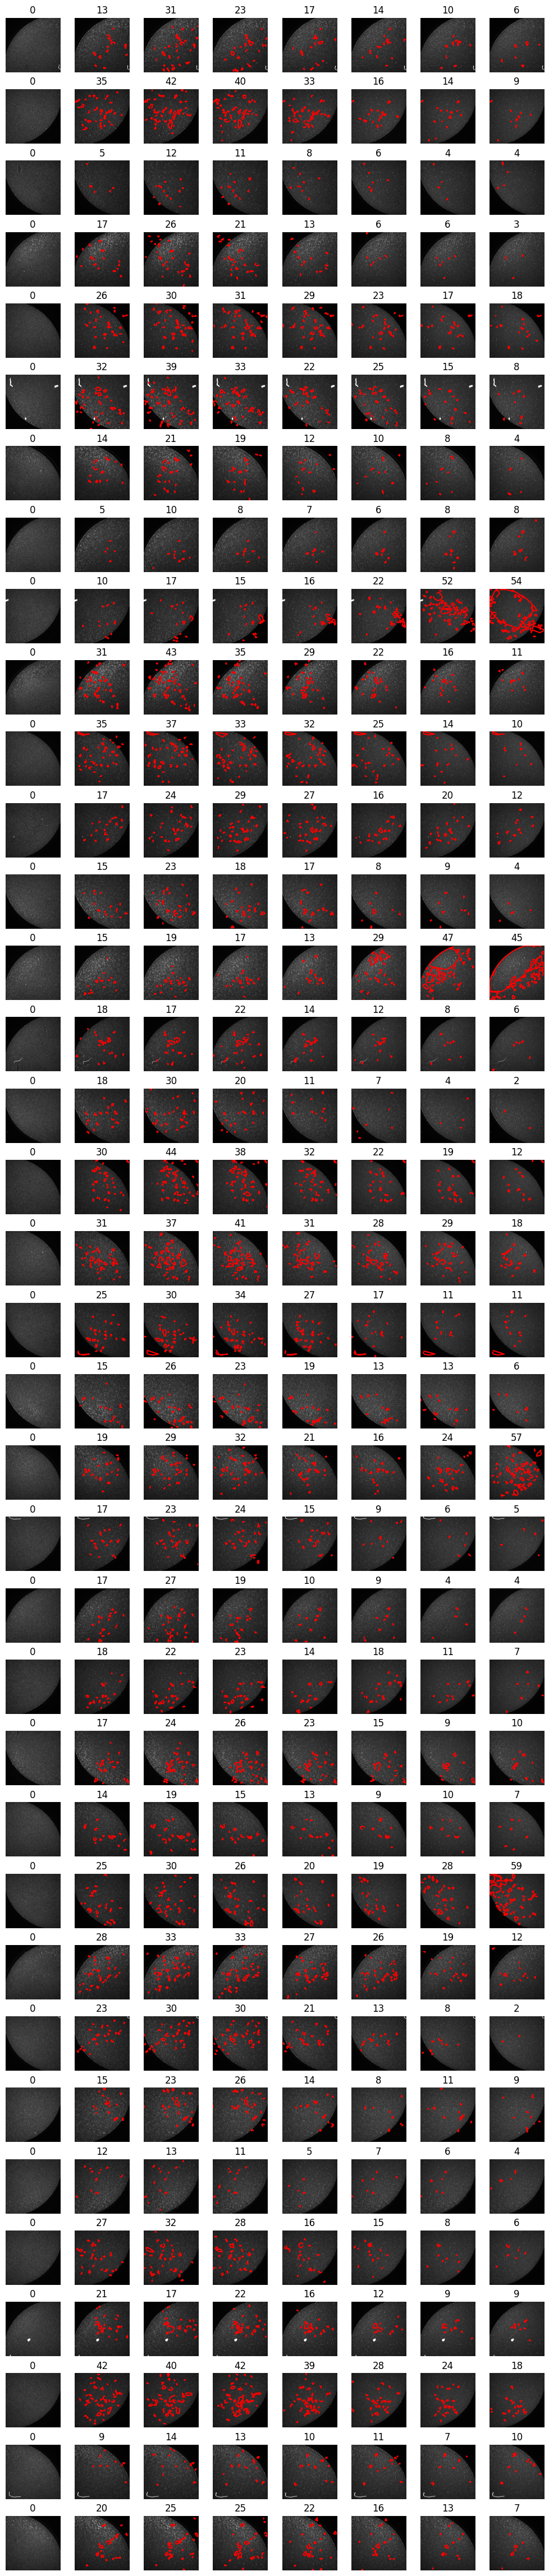

In [3]:
images = [dmso_img_files, inhibitor_img_files]
csv_files = [dmso_csv_files, inhibitor_csv_files]
names = ["DMSO", "Inhibitor"]
frames = [0, 15, 20, 25, 30, 35, 40, 45]

for g, group in enumerate(names):
    print(group)
    fig, axes = plt.subplots(nrows=len(images[g]), ncols=len(frames), figsize=(10, 50))
    for i, (img, csv) in enumerate(zip(images[g], csv_files[g])):
        for j, frame in enumerate(frames):
            num_cluster, pos, labels = frame_clusters_with_dbscan(csv, frame, db_eps=DB_EPS, db_min_sample=DB_MIN_SAMPLES)
            plot_clusters(axes[i, j], img, frame, pos, labels)
            axes[i, j].set_title(f"{num_cluster}")
            axes[i, j].axis("off")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()